In [1]:
%matplotlib inline
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Download mnist datasets using tensorflow

In [2]:
from tensorflow.examples.tutorials.mnist import input_data


In [3]:
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Model Inputs
* We need 2 inputs , one for generator and one for discrimintator. 
* Discriminator input as input_real
* Generator input as input_z

In [4]:
def model_input(real_dim,z_dim):
    input_real = tf.placeholder(dtype=tf.float32,shape=(None,real_dim),name='input_real')
    input_z = tf.placeholder(dtype=tf.float32,shape=(None,z_dim),name='input_z')
    return input_real,input_z

## Generator 
* Build a simple network with 1 hidden layer . Use Leaky Relu so that gradients pass backward unimpeded.


In [5]:
def generator(z,out_dim,n_units=128,alpha=0.01,reuse=False):
    with tf.variable_scope('generator',reuse=reuse):
        h1 = tf.layers.dense(z,n_units,activation=None)
        h1 = tf.maximum(alpha * h1,h1)
        logits = tf.layers.dense(h1,out_dim,activation=None)
        out = tf.tanh(logits)
        return out

## Discriminator
* Build a simple discriminator with architecture similar to generator with a sigmoid.

In [6]:
def discriminator(x,n_units=128,alpha=0.01,reuse=False):
    with tf.variable_scope('discriminator',reuse=reuse):
        h1 = tf.layers.dense(x,n_units,activation=None)
        h1 = tf.maximum(alpha * h1,h1)
        logits = tf.layers.dense(h1,1)
        out = tf.sigmoid(logits)
        return out,logits

## Network Hyperparameters

In [14]:
input_dim = 784
z_dim = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smoothing =0.1


## Build Network

In [15]:
tf.reset_default_graph()
input_real , input_z = model_input(input_dim,z_dim)

In [16]:
g_model = generator(input_z,input_dim,n_units=g_hidden_size,alpha=alhpa,reuse=False)
d_model_real ,d_logits_real = discriminator(input_real,n_units=d_hidden_size,alpha=alhpa,reuse=False)
d_model_fake ,d_logits_fake = discriminator(g_model,n_units=d_hidden_size,alpha=alpha,reuse=True)

## Discriminator and Generator Losses

In [17]:
d_real_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_logits_real) * (1- smoothing),
        logits=d_logits_real))
d_fake_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.zeros_like(d_logits_fake),
        logits=d_logits_fake))
d_loss = d_real_loss + d_fake_loss

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_logits_fake),
        logits=d_logits_fake))

## Optimizers

In [18]:
learning_rate = 0.002
var_list = tf.trainable_variables()
g_var_list = [var for var in var_list if var.name.startswith('generator')]
d_var_list = [var for var in var_list if var.name.startswith('discriminator')]
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss,var_list=d_var_list)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss,var_list=g_var_list)


In [19]:
mnist.train.num_examples//100

550

In [20]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_var_list)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            batch_images = batch[0].reshape((batch_size,784))
            batch_images = batch_images * 2 - 1
            
            batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
            
            #Run the optimizers 
            
            _ = sess.run(d_train_opt,feed_dict={input_real:batch_images,input_z:batch_z})
            _ = sess.run(g_train_opt,feed_dict={input_z:batch_z})
        
        train_loss_d = sess.run(d_loss,feed_dict={input_real:batch_images,input_z:batch_z})
        train_loss_g = sess.run(g_loss,feed_dict={input_z:batch_z})
        print('epoch {}'.format(e),
             'Discriminator loss: {:.4f}'.format(train_loss_d),
             'Generator loss: {:.4f}...'.format(train_loss_g))
        
        losses.append((train_loss_d,train_loss_g))
        sample_z = np.random.uniform(-1,1,size=(16,100))
        gen_samples = sess.run(
            generator(input_z,input_dim,reuse=True),
            feed_dict={input_z:sample_z})
        samples.append(gen_samples)
        saver.save(sess,'./checkpoints/generator.ckpt')
        

pkl.dump(samples,open('train_samples.pkl','wb'))





epoch 0 Discriminator loss: 0.3783 Generator loss: 3.2671...
epoch 1 Discriminator loss: 0.4419 Generator loss: 2.5309...
epoch 2 Discriminator loss: 0.5034 Generator loss: 3.2556...
epoch 3 Discriminator loss: 1.3184 Generator loss: 2.5003...
epoch 4 Discriminator loss: 0.9000 Generator loss: 2.2285...
epoch 5 Discriminator loss: 1.3470 Generator loss: 2.8605...
epoch 6 Discriminator loss: 1.0643 Generator loss: 1.5605...
epoch 7 Discriminator loss: 0.9535 Generator loss: 2.2237...
epoch 8 Discriminator loss: 0.7360 Generator loss: 2.5884...
epoch 9 Discriminator loss: 1.0120 Generator loss: 3.1584...
epoch 10 Discriminator loss: 1.4660 Generator loss: 1.4608...
epoch 11 Discriminator loss: 1.3268 Generator loss: 2.3178...
epoch 12 Discriminator loss: 0.8016 Generator loss: 2.5247...
epoch 13 Discriminator loss: 1.0190 Generator loss: 2.4579...
epoch 14 Discriminator loss: 0.7947 Generator loss: 2.8822...
epoch 15 Discriminator loss: 0.7137 Generator loss: 2.0787...
epoch 16 Discrimin

In [23]:
losses = np.array(losses)

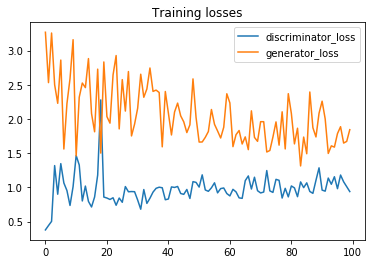

In [35]:
plt.plot(losses.T[0],label='discriminator_loss')
plt.plot(losses.T[1],label='generator_loss')
plt.title('Training losses')
plt.legend()

In [38]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [53]:
def view_samples(epoch,samples):
    fig,axes = plt.subplots(figsize=(7,7),nrows=4,ncols=4,sharex=True,sharey=True)
    for ax,img in zip(axes.flatten(),samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)),cmap='Greys_r')
    return fig , axes

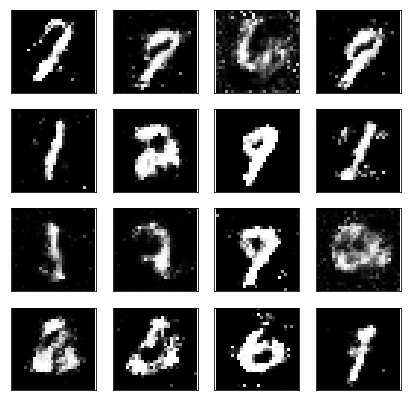

In [54]:
_ = view_samples(-1,samples)

In [61]:
saver = tf.train.Saver(var_list = g_var_list)

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


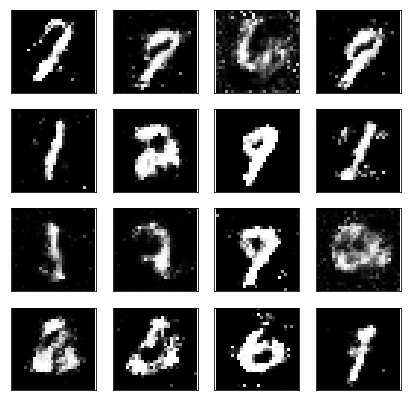

In [64]:
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints'))
    samples = np.random.uniform(-1,1,(16,100))
    gen_samples = sess.run(generator(input_z,input_dim,reuse=True)
                           ,feed_dict={input_z:sample_z})
_ = view_samples(0,[gen_samples])